In [83]:
import pandas as pd
import librosa as mimosa
import audioread
import os
import matplotlib as plt
import seaborn as sns

musicGender = os.listdir("musics") # returns list
genderlabel = []
musicData = []

for gender in musicGender:
    genderMusics = os.listdir('./musics/{}'.format(gender))
    for music in genderMusics:
        genderlabel.append(gender)
        amplitude, sr = mimosa.load('./musics/{}'.format(gender)+'/{}'.format(music))
        
        musicData.append(amplitude)


In [84]:
tempo = []

for i, data in enumerate(musicData):
    t, beat = mimosa.beat.beat_track(y=musicData[i])
    print('{}'.format(t)+ " {}".format(i))
    tempo.append(t)


123.046875 0
67.99958881578948 1
161.4990234375 2
63.02400914634146 3
135.99917763157896 4
69.83741554054055 5
71.77734375 6
92.28515625 7
83.35433467741936 8
80.74951171875 9
161.4990234375 10
161.4990234375 11
184.5703125 12
107.666015625 13
151.99908088235293 14
103.359375 15
198.76802884615384 16
172.265625 17
83.35433467741936 18
123.046875 19
135.99917763157896 20
99.38401442307692 21
95.703125 22
184.5703125 23
103.359375 24
92.28515625 25
83.35433467741936 26
92.28515625 27
103.359375 28
129.19921875 29
151.99908088235293 30
151.99908088235293 31
143.5546875 32
151.99908088235293 33
184.5703125 34
129.19921875 35
151.99908088235293 36
123.046875 37
86.1328125 38
117.45383522727273 39
172.265625 40
129.19921875 41
89.10290948275862 42
129.19921875 43
135.99917763157896 44
129.19921875 45
123.046875 46
151.99908088235293 47
123.046875 48
123.046875 49
135.99917763157896 50
99.38401442307692 51
151.99908088235293 52
103.359375 53
89.10290948275862 54
135.99917763157896 55
161.4990

In [81]:
d = {'tempo': tempo, 'genderlabel':genderlabel}
tempoDF = pd.DataFrame(data=d)

for t in tempoDF:
    print(tempoDF.index)

1000
1000
1000
['blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'blues', 'classical', 'classical', 'classical', 'classical', 'classical', 'classical', 'class

<Axes: xlabel='genderlabel', ylabel='tempo'>

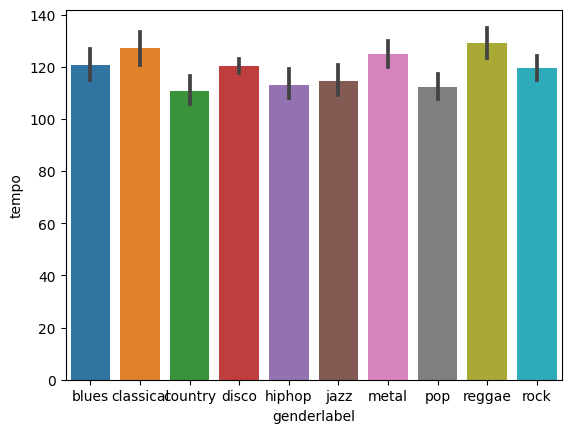

In [82]:
sns.barplot(data=tempoDF, x="genderlabel"  ,y="tempo")

In [102]:
import sklearn.preprocessing as preProSkL

labelEncoder = preProSkL.LabelEncoder()
labelEncoded = labelEncoder.fit(genderlabel)
labelEncodedTrans = labelEncoded.transform(genderlabel)
#  inverse_transform to revert to normal



In [ ]:
import numpy as np

mfcc_specData = []

for i, data in enumerate(musicData):
    melSpec = mimosa.feature.melspectrogram(y = data)    
    melSpec_to_db = mimosa.power_to_db(melSpec, ref=np.max)
    mfcc_specData.append(melSpec_to_db)


print(mfcc_specData)

In [104]:
import sklearn.model_selection as modelSelec

X_train, X_test, y_train, y_test = modelSelec.train_test_split(mfcc_specData, labelEncodedTrans, test_size=0.30, random_state=42)
